In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from matplotlib.animation import PillowWriter, FuncAnimation
import xarray as xr
import regionmask

In [5]:

fN = ("Datos\Land_and_Ocean_EqualArea.nc") 

ds = xr.open_dataset(fN)
years_approx = np.floor(ds['time'])
temp = ds['temperature'].groupby(years_approx).mean('time')
longitude = ds.variables['longitude'][:]  
latitude = ds.variables['latitude'][:]
time = ds.variables['time'][:]
land_mask = ds.variables['land_mask'][:]
temperature = ds.variables['temperature'][:]
climatology = ds.variables['climatology'][:]

<GeoAxesSubplot: >

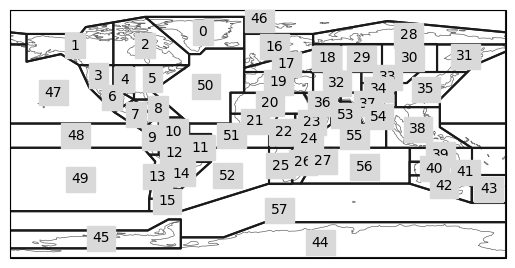

In [6]:
# Define las regiones AR6
ar6_regions = regionmask.defined_regions.ar6.all

# Crea una máscara de regiones para cada punto de la grilla
region_mask = ar6_regions.mask(ds.longitude, ds.latitude, wrap_lon=True)

ar6_all = regionmask.defined_regions.ar6.all
ar6_all.plot()

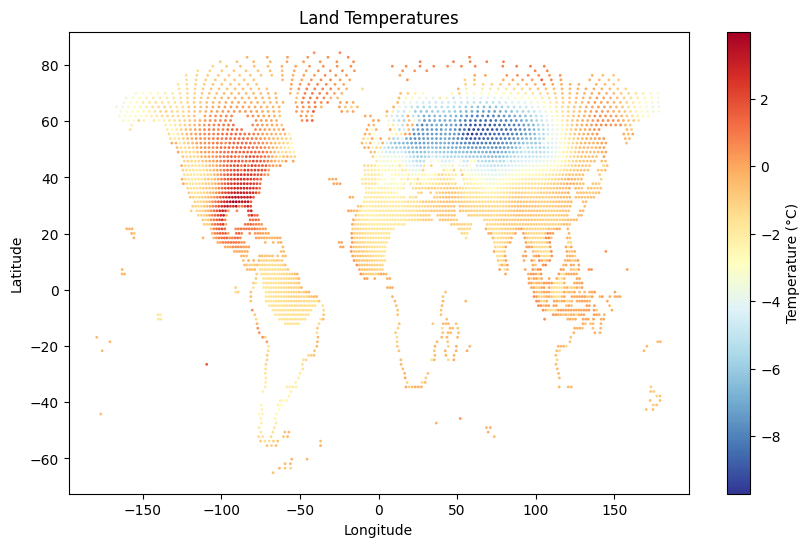

In [9]:
# Aplicar la máscara de tierra a los datos de temperatura
# Considerar cualquier valor de 'land_mask' > 0 como tierra
is_land = ds['land_mask'] > 0
temperature_land_only = ds['temperature'].isel(time=0).where(is_land, drop=True)

# Preparar los datos de latitud y longitud para el plot
longitude = ds['longitude'].values[is_land]
latitude = ds['latitude'].values[is_land]
temperature_values = temperature_land_only.values

# Crear el mapa usando scatter para mostrar solo las temperaturas de la tierra


plt.figure(figsize=(10, 6))
plt.scatter(longitude, latitude, c=temperature_values, s=1, cmap='RdYlBu_r')
plt.colorbar(label='Temperature (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Land Temperatures')
plt.show()


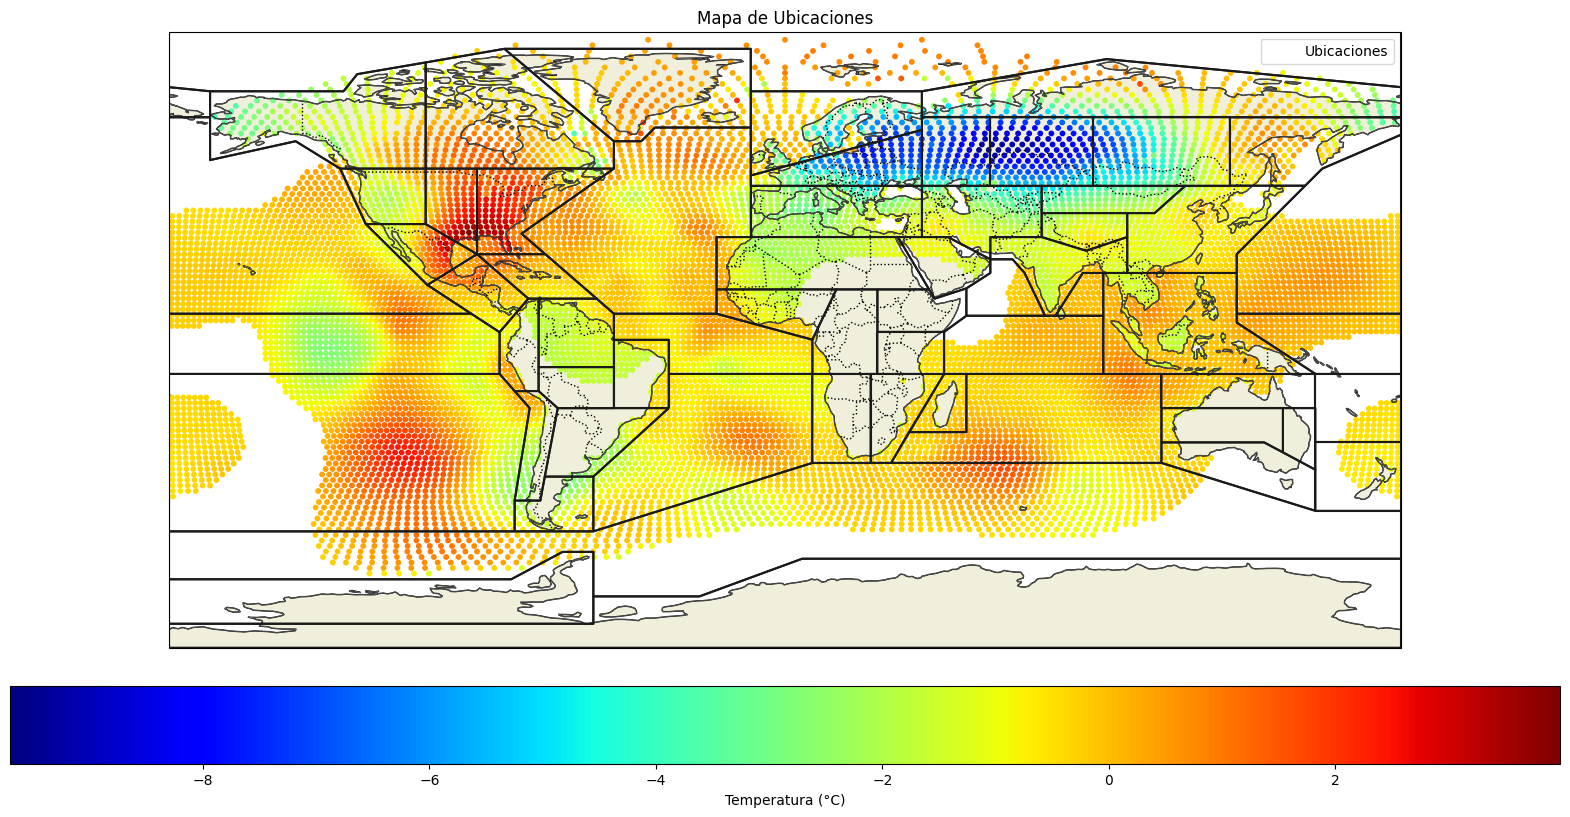

In [7]:
# Crear una figura y un subplot con proyección
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()

# Añadir características al mapa
ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.OCEANS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Añadir los puntos de datos al mapa
scatter =ax.scatter(longitude, latitude,  c=temperature[0], cmap='jet', s=10, transform=ccrs.Geodetic(), label='Ubicaciones')
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label('Temperatura (°C)')

ar6_all.plot(ax=ax, add_label=False)
# Añadir leyenda y título
ax.legend()
ax.set_title('Mapa de Ubicaciones')

plt.show()


In [ ]:


# Suponemos que 'temperature' es un array 2D: tiempo x datos
num_times = temperature.shape[0]

# Crear una figura y un subplot con proyección
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()

# Añadir características al mapa
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Añadir los puntos de datos al mapa
scatter = ax.scatter(longitude, latitude, c=temperature[0], cmap='jet', s=10, transform=ccrs.Geodetic())
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label('Temperatura (°C)')

ar6_all.plot(ax=ax, add_label=False)
ax.legend()
ax.set_title('Mapa de Ubicaciones')

# Función para actualizar los datos del scatter plot en cada cuadro
def update(frame):
    scatter.set_array(temperature[frame])  # Actualiza los colores de los puntos

# Crear y guardar la animación
ani = FuncAnimation(fig, update, frames=num_times, repeat=True)
ani.save('temperature_animation.gif', writer=PillowWriter(fps=7))  # Aumenta fps para una animación más rápida

plt.show()


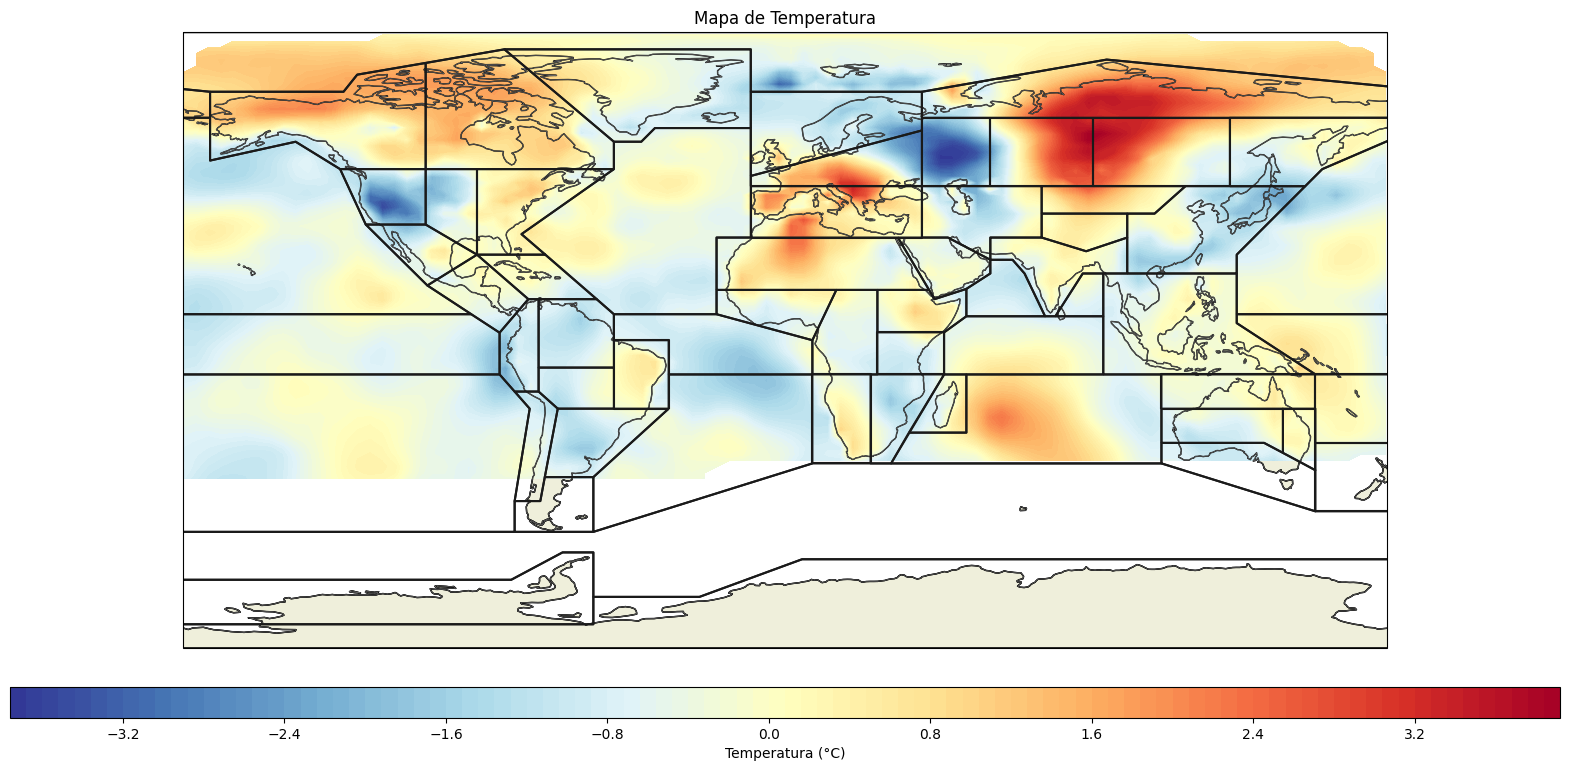

In [8]:

# Definir los límites de la malla sobre la que se interpolan los datos
grid_lon = np.linspace(ds['longitude'].min(), ds['longitude'].max(), 100)
grid_lat = np.linspace(ds['latitude'].min(), ds['latitude'].max(), 100)

# Crear malla de coordenadas
lon, lat = np.meshgrid(grid_lon, grid_lat)

# Interpolar los datos de temperatura sobre la malla
grid_temp = griddata((ds['longitude'], ds['latitude']), temperature[700], (lon, lat), method='cubic')

# Crear figura y eje con proyección de Cartopy
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([ds['longitude'].min() - 5, ds['longitude'].max() + 5, ds['latitude'].min() - 5, ds['latitude'].max() + 5], crs=ccrs.PlateCarree())

# Añadir características del mapa
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ar6_all.plot(ax=ax, add_label=False)
# Visualizar la malla de temperatura
contour = ax.contourf(lon, lat, grid_temp, levels=100, cmap='RdYlBu_r', transform=ccrs.PlateCarree())

# Añadir barra de color
cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, aspect=50)
cbar.set_label('Temperatura (°C)')

# Añadir título
ax.set_title('Mapa de Temperatura')

plt.show()


In [ ]:


# Suponiendo que 'climatology' es un array con una dimensión de tiempo en la primera dimensión
num_times = temperature.shape[0]

# Definir los límites comunes para la escala de colores
min_temp = np.min(temperature)
max_temp = np.max(temperature)

# Preparar la malla de coordenadas
grid_lon = np.linspace(ds['longitude'].min(), ds['longitude'].max(), 100)
grid_lat = np.linspace(ds['latitude'].min(), ds['latitude'].max(), 100)
lon, lat = np.meshgrid(grid_lon, grid_lat)

# Función para crear mapas
def make_map(i):
    ax.clear()
    grid_temp = griddata((ds['longitude'], ds['latitude']), temperature[i], (lon, lat), method='cubic')
    contour = ax.contourf(lon, lat, grid_temp, levels=100, cmap='RdYlBu_r', vmin=min_temp, vmax=max_temp, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE)
    ax.set_title('Mapa de Temperatura - Tiempo {}'.format(i))
    return contour

# Crear figura y eje con proyección de Cartopy
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Animación
ani = FuncAnimation(fig, make_map, frames=num_times, repeat=True)

# Guardar como GIF
ani.save('temperature_animation.gif', writer=PillowWriter(fps=15))
